
### NOTE: This is historic data. The most up-to-date code is contained in `report.ipynb`.
---
Using the `stock_data_frame_builder.py` utility I created, I could massage all the stock data into one MASSIVE csv file 
(~800MB) that contains all stock data (for stocks with at least ~ 4 years of price data) from 1977-2017.

Here's a sample, showing the data from AAPL (Apple Computers). We can create a simple boolean table and then use it to
filter a new DataFrame containing only matching rows. 

First, Let's choose how many days we want to take into consideration. I chose 500, or approximately 2 years of date.

In [1]:
LOOK_BACK = 500

In [2]:
import pandas as pd

stock_data = pd.read_csv("compiled_data.zip", error_bad_lines=False, index_col="Date", parse_dates=True)
stock_data = stock_data.drop(columns='Unnamed: 0')  # Result of how to_csv saved the data.

def select_stock(stock_ticker):
    is_ticker = stock_data['ticker'] == stock_ticker
    selected_stock = stock_data[is_ticker]
    
    return selected_stock

apple_stock = select_stock('AAPL')
apple_stock.describe()

,Open,High,Low,Close,Volume
count,8364.000000,8364.000000,8364.000000,8364.000000,8.364000e+03
mean,22.284350,22.495867,22.054244,22.281018,1.066416e+08
std,37.763402,38.057733,37.447432,37.764469,9.935187e+07
min,0.233050,0.235640,0.230510,0.230510,0.000000e+00
25%,1.137100,1.164200,1.112800,1.137100,4.384365e+07
50%,1.632800,1.663400,1.600600,1.628250,7.481383e+07
75%,23.739000,23.930500,23.335750,23.694500,1.320534e+08
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09


I checked my data visually to see if it looks good. If you plot End of Day (closing) price with Date, you will see a classic line chart of a stock that you might find on Yahoo finance or NASDAQ's site.

In [1]:
apple_stock.plot(y='Close',legend=False)

NameError: name 'apple_stock' is not defined

Now, lets convert this data to something usable by keras. I'm going to use NumPy, as NumPy arrays are easily transferred
into Keras structures. I will take 4/5ths of the data for training, and the remaining 1/5th will be for 
testing/validation.

For a quick test, lets just focus on Closing price as a data point.



In [5]:
def prep_stock_data(stock_df,stock_feature='Close'):

    frame_split = int(round(len(stock_df.index)*(4/5)))

    training_data = stock_df[stock_feature]
    training_data = pd.DataFrame(training_data)

    x_train_raw = training_data.iloc[:frame_split]
    x_test_raw = training_data.iloc[frame_split:frame_split+LOOK_BACK*2] # This was found by trial and error

    prepared_data = {
        'x_train': x_train_raw,
        'x_test': x_test_raw
    }
    
    return prepared_data

converted_stock_data = prep_stock_data(apple_stock)

print(converted_stock_data['x_train'].tail())

x_train_raw = converted_stock_data['x_train']
x_test_raw = converted_stock_data['x_test']

             Close
Date              
2011-03-16  42.261
2011-03-17  42.854
2011-03-18  42.346
2011-03-21  43.452
2011-03-22  43.696


As Keras uses NumPy Arrays, I convert my Pandas Dataframes accordingly. Then, to make the data digestable by the `Sequential()` model, I re-shape my data to be one-dimensional nested arrays.

The secret sauce here comes from [this excellent overview post][1]; though I've generalized it and I'm using a *much* larger dataset. The basic point of the `for` loop in the below code block is that I make my label a spesific single datapoint, and the input is the previous LOOK_BACK days of the same data.

The NN will then attempt to build a network that can reliably predict the datapoint for X given that feed-in data.

[1]:https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [6]:
import numpy as np

data_size = x_train_raw.shape[0]

x_train_np = np.array(x_train_raw)

x_train = []
y_train = []

for i in range (LOOK_BACK, data_size):
    x_train.append(x_train_np[i-LOOK_BACK:i, 0])
    y_train.append(x_train_np[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Now, at long last, we are ready to actually use some ML! I trained this set over 500 day's lookback data.

In [7]:
from keras import models
from keras import layers

model = models.Sequential()

#  LSTM Networks are repeatedly referred to as the best option for forward-looking predictions on Stocks
#  See: - https://en.wikipedia.org/wiki/Long_short-term_memory
#       - https://github.com/DarkKnight1991/Stock-Price-Prediction

model.add(layers.LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(layers.LSTM(units = 75, return_sequences = True))
model.add(layers.LSTM(units = 50))

# I chose to normalize the data at this point, given how many inputs there are in the form of stock data (usually >1000!)
model.add(layers.BatchNormalization())

# This single output node should reflect a predicted price for Date(N) based on the previous LOOK_BACK number of datapoints.
model.add(layers.Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 5, batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
6191/6191 [==============================] - 175s 28ms/step - loss: 28.4794
Epoch 2/5
6191/6191 [==============================] - 163s 26ms/step - loss: 8.1252
Epoch 3/5
6191/6191 [==============================] - 155s 25ms/step - loss: 3.2379
Epoch 4/5
6191/6191 [==============================] - 159s 26ms/step - loss: 2.8378
Epoch 5/5
6191/6191 [==============================] - 166s 27ms/step - loss: 2.6113


In [8]:
def predict_on_data(dict_of_data, keras_model):
    train_raw = dict_of_data['x_train']
    test_raw = dict_of_data['x_test']
    
    test_data_size = test_raw.shape[0]
    actuals = test_raw.values

    combined_total = pd.concat((train_raw, test_raw), axis = 0)
    validation_data = combined_total[combined_total.shape[0] - test_data_size - LOOK_BACK:].values


    x_test_np = np.array(test_raw)
    x_test = []

    for i in range (LOOK_BACK, test_data_size):
        x_test.append(validation_data[i-LOOK_BACK:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return keras_model.predict(x_test)

predictions = predict_on_data(converted_stock_data, model)
predictions=pd.DataFrame(predictions)
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 1 columns):
0    500 non-null float32
dtypes: float32(1)
memory usage: 2.0 KB


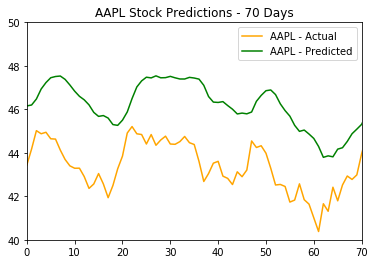

In [17]:
import matplotlib.pyplot as plt
plt.plot(converted_stock_data['x_test'].values, color = 'orange', label = 'AAPL - Actual')
plt.plot(predictions, color = 'green', label = 'AAPL - Predicted')
plt.title('AAPL Stock Predictions - 70 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,70])
axes.set_ylim([40,50])
plt.show()

Hey, that's not bad! Its persistantly high though.
Let's zoom out and see how the full prediction over 30 dates fared...

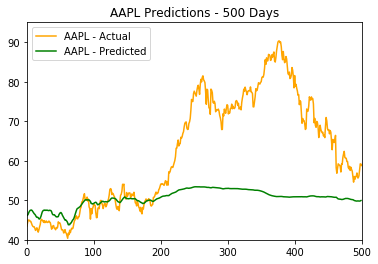

In [10]:
plt.plot(converted_stock_data['x_test'].values, color = 'orange', label = 'AAPL - Actual')
plt.plot(predictions, color = 'green', label = 'AAPL - Predicted')
plt.title('AAPL Predictions - 500 Days')
plt.legend()

axes = plt.gca()
axes.set_xlim([0,500])
axes.set_ylim([40,95])
plt.show()

Ah. So there is clearly some limitations here. 

---

Say, how would a different stock do on this data?

In [11]:
ford_stock = select_stock('F')
converted_ford_data = prep_stock_data(ford_stock)

ford_predictions = predict_on_data(converted_ford_data, model)
ford_predictions= pd.DataFrame(ford_predictions)
ford_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 1 columns):
0    500 non-null float32
dtypes: float32(1)
memory usage: 2.0 KB


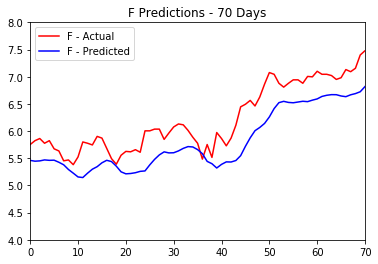

In [12]:
plt.plot(converted_ford_data['x_test'].values, color = 'red', label = 'F - Actual')
plt.plot(ford_predictions, color = 'blue', label = 'F - Predicted')
plt.title('F Predictions - 70 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,70])
axes.set_ylim([4,8])
plt.show()

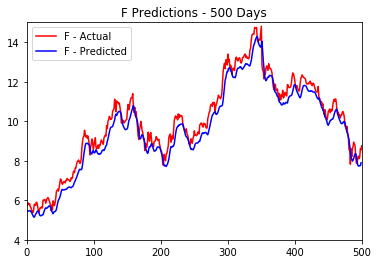

In [13]:
plt.plot(converted_ford_data['x_test'].values, color = 'red', label = 'F - Actual')
plt.plot(ford_predictions, color = 'blue', label = 'F - Predicted')
plt.title('F Predictions - 500 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,500])
axes.set_ylim([4,15])
plt.show()

Woah! That's way better...

In [14]:
microsoft_stock = select_stock('MSFT')
converted_microsoft_data = prep_stock_data(microsoft_stock)

microsoft_predictions = predict_on_data(converted_microsoft_data, model)
microsoft_predictions= pd.DataFrame(microsoft_predictions)
microsoft_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 1 columns):
0    500 non-null float32
dtypes: float32(1)
memory usage: 2.0 KB


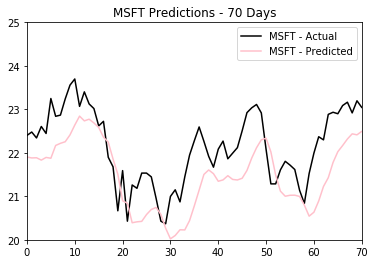

In [15]:
plt.plot(converted_microsoft_data['x_test'].values, color = 'black', label = 'MSFT - Actual')
plt.plot(microsoft_predictions, color = 'pink', label = 'MSFT - Predicted')
plt.title('MSFT Predictions - 70 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,70])
axes.set_ylim([20,25])
plt.show()

MSFT seems to be accurate, but shows a more significant lag than the previous examples.

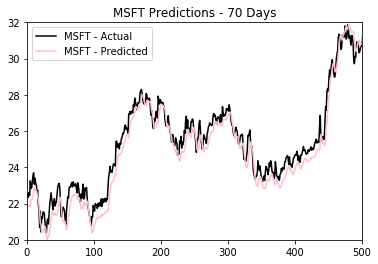

In [16]:
plt.plot(converted_microsoft_data['x_test'].values, color = 'black', label = 'MSFT - Actual')
plt.plot(microsoft_predictions, color = 'pink', label = 'MSFT - Predicted')
plt.title('MSFT Predictions - 70 Days')
plt.legend()

# Limit Axes
axes = plt.gca()
axes.set_xlim([0,500])
axes.set_ylim([20,32])
plt.show()